In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module

In [2]:
from flamingchoripan.files import search_for_filedirs
from lchandler import C_

root_folder = '../../surveys-save'
filedirs = search_for_filedirs(root_folder, fext=C_.EXT_RAW_LIGHTCURVE)

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.progress_bars import ProgressBar
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir

filedir = f'../../surveys-save/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds'
filedict = get_dict_from_filedir(filedir)
root_folder = filedict['_rootdir']
cfilename = filedict['_cfilename']
survey = filedict['survey']
lcdataset = load_pickle(filedir)
print(lcdataset)

LCDataset:
[outliers - samples 10]
(.) obs_samples=541 - min_len=14 - max_dur=408.0[days] - dur(p50)=133.8[days] - cadence(p50)=1.0[days]
(g) obs_samples=260 - min_len=6 - max_dur=408.0[days] - dur(p50)=133.8[days] - cadence(p50)=3.0[days]
(r) obs_samples=281 - min_len=8 - max_dur=376.0[days] - dur(p50)=128.7[days] - cadence(p50)=3.0[days]
   |█▌      | SLSN - 2/10 (20.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
   |████    | allSNII - 5/10 (50.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint - samples 48]
(.) obs_samples=1,107 - min_len=7 - max_dur=298.1[days] - dur(p50)=40.5[days] - cadence(p50)=1.0[days]
(g) obs_samples=450 - min_len=0 - max_dur=221.7[days] - dur(p50)=28.0[days] - cadence(p50)=2.9[days]
(r) obs_samples=657 - min_len=4 - max_dur=298.1[days] - dur(p50)=38.9[days] - cadence(p50)=2.9[days]
   |█▏      | SLSN - 7/48 (14.58%)
   |███▊    | SNIa - 23/48 (47.92%)
   |▌       | SN

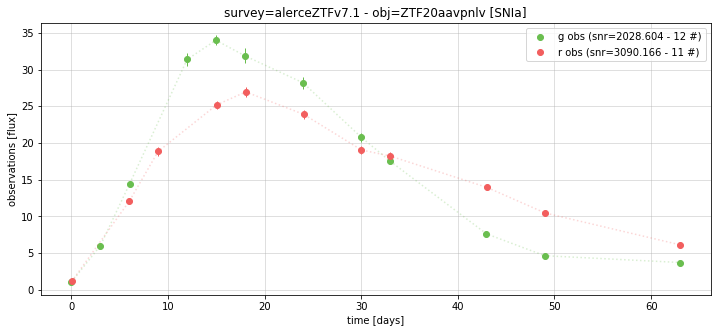

In [4]:
import flamingchoripan.lists as lists
import matplotlib.pyplot as plt
from lchandler.plots.lc import plot_lightcurve

lcset = lcdataset['raw']
lcobj_name = lcset.get_random_lcobj_name()
lcobj_name = 'ZTF20aavpnlv'
lcobj = lcset[lcobj_name]
fig, ax = plt.subplots(1,1, figsize=(12,5))
for kb,b in enumerate(lcset.band_names):
    plot_lightcurve(ax, lcobj, b, label=f'{b} obs')
ax.set_title(f'survey={lcset.survey} - obj={lcobj_name} [{lcset.class_names[lcobj.y]}]')
ax.set_xlabel('time [days]')
ax.set_ylabel('observations [flux]')
ax.legend()
ax.grid(alpha=0.5)

In [5]:
%load_ext autoreload
%autoreload 2

kfolds = 5
new_sets_props = {
    'raw_train':0.6,
    'raw_val':0.2,
    'raw_test':0.2,
    }
lcdataset.split('raw', new_sets_props, kfolds)
print(lcdataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LCDataset:
[outliers - samples 10]
(.) obs_samples=541 - min_len=14 - max_dur=408.0[days] - dur(p50)=133.8[days] - cadence(p50)=1.0[days]
(g) obs_samples=260 - min_len=6 - max_dur=408.0[days] - dur(p50)=133.8[days] - cadence(p50)=3.0[days]
(r) obs_samples=281 - min_len=8 - max_dur=376.0[days] - dur(p50)=128.7[days] - cadence(p50)=3.0[days]
   |█▌      | SLSN - 2/10 (20.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
   |████    | allSNII - 5/10 (50.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint - samples 48]
(.) obs_samples=1,107 - min_len=7 - max_dur=298.1[days] - dur(p50)=40.5[days] - cadence(p50)=1.0[days]
(g) obs_samples=450 - min_len=0 - max_dur=221.7[days] - dur(p50)=28.0[days] - cadence(p50)=2.9[days]
(r) obs_samples=657 - min_len=4 - max_dur=298.1[days] - dur(p50)=38.9[days] - cadence(p50)=2.9[days]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


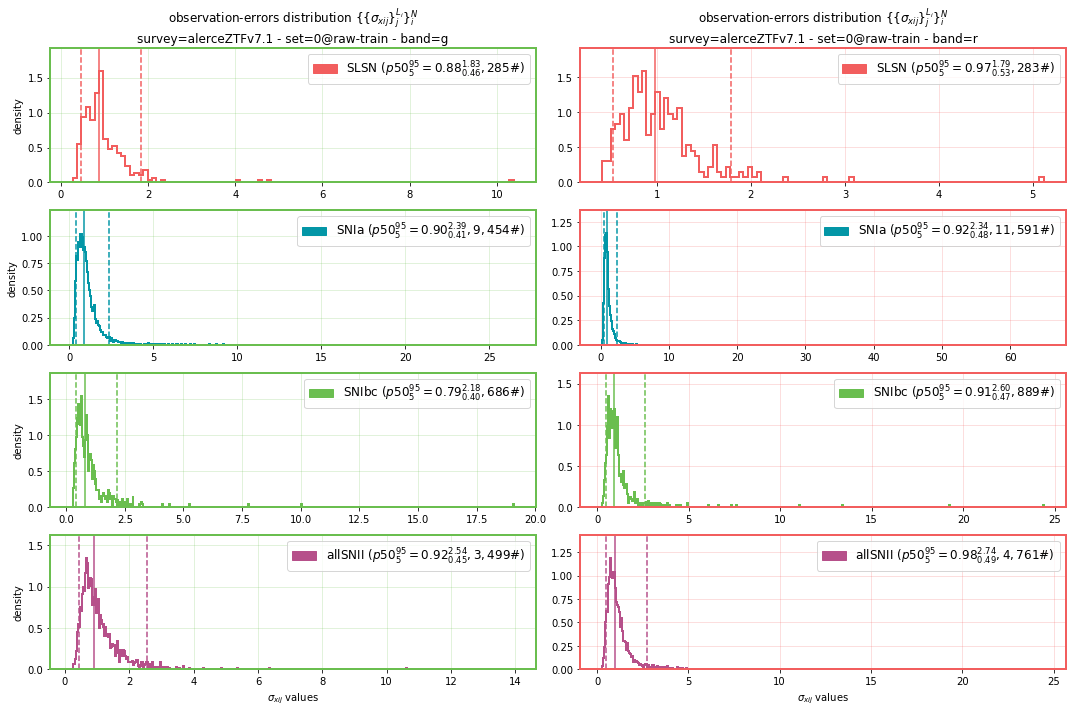

In [6]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_sigma_distribution

plot_sigma_distribution(lcdataset, '0@raw_train')

In [7]:
%load_ext autoreload
%autoreload 2

sigma_clipping_kwargs = {
    'sigma_n':1,
    'sigma_m':10, # 1, 3, 5
    'apply_lower_bound':False,
    'verbose':0,
}
for kf in range(0,3):
    for ks,set_name in enumerate([f'{kf}@raw_train', f'{kf}@raw_val', f'{kf}@raw_test']):
        lcdataset.sigma_clipping(set_name, set_name.replace('raw_',''), **sigma_clipping_kwargs)

print(lcdataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LCDataset:
[outliers - samples 10]
(.) obs_samples=541 - min_len=14 - max_dur=408.0[days] - dur(p50)=133.8[days] - cadence(p50)=1.0[days]
(g) obs_samples=260 - min_len=6 - max_dur=408.0[days] - dur(p50)=133.8[days] - cadence(p50)=3.0[days]
(r) obs_samples=281 - min_len=8 - max_dur=376.0[days] - dur(p50)=128.7[days] - cadence(p50)=3.0[days]
   |█▌      | SLSN - 2/10 (20.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
   |████    | allSNII - 5/10 (50.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint - samples 48]
(.) obs_samples=1,107 - min_len=7 - max_dur=298.1[days] - dur(p50)=40.5[days] - cadence(p50)=1.0[days]
(g) obs_samples=450 - min_len=0 - max_dur=221.7[days] - dur(p50)=28.0[days] - cadence(p50)=2.9[days]
(r) obs_samples=657 - min_len=4 - max_dur=298.1[days] - dur(p50)=38.9[days] - cadence(p50)=2.9[days]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


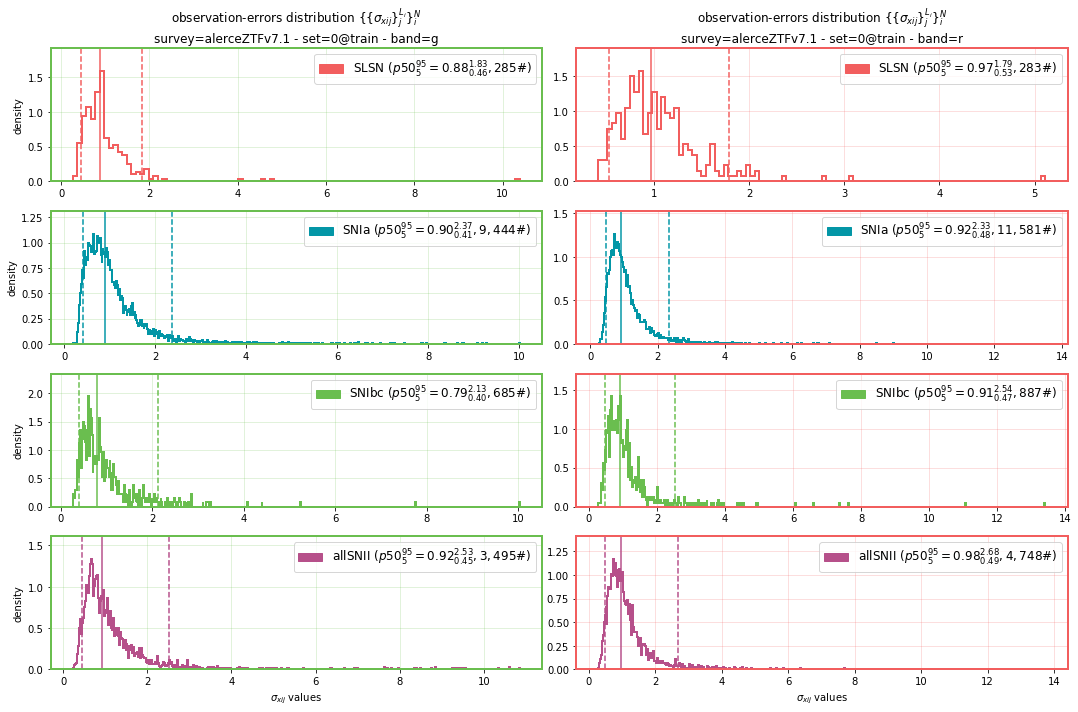

In [8]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_sigma_distribution

plot_sigma_distribution(lcdataset, '0@train')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


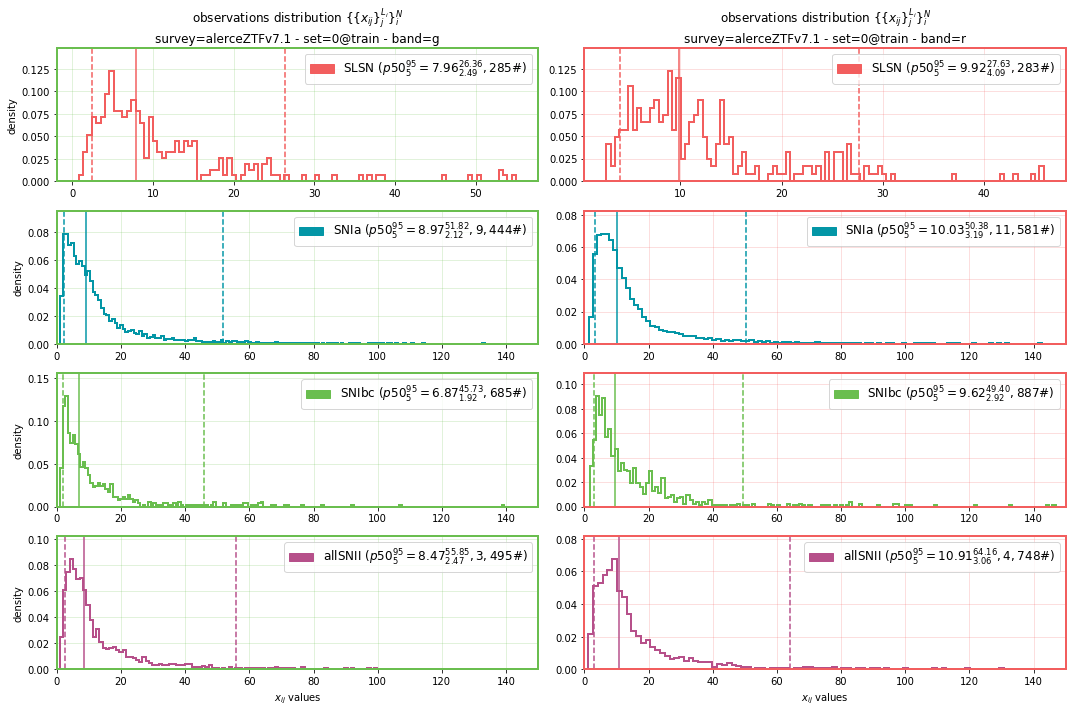

In [9]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_values_distribution

plot_values_distribution(lcdataset, '0@train', 'obs')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


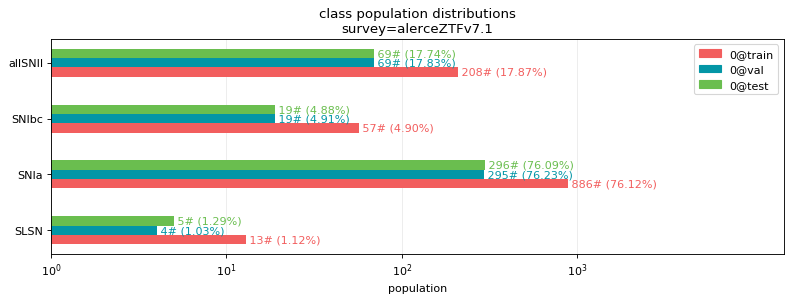

In [10]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_class_distribution

plot_class_distribution(lcdataset, ['0@train', '0@val', '0@test'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


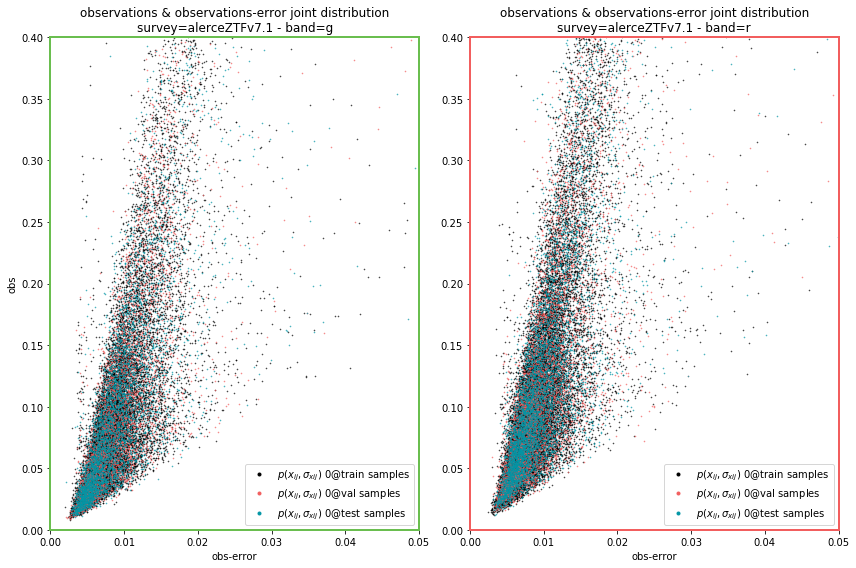

In [11]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.scatters import plot_obs_obse_scatter

plot_obs_obse_scatter(lcdataset, ['0@train', '0@val', '0@test'])

In [12]:
from flamingchoripan.files import load_pickle, save_pickle
from lchandler import C_

new_cfilename = f'{cfilename}'
save_filedir = f'{root_folder}/{new_cfilename}.{C_.EXT_SPLIT_LIGHTCURVE}'
save_pickle(save_filedir, lcdataset)